In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
import warnings
import scipy.stats as st
warnings.filterwarnings('ignore')
from collections import namedtuple
from statsmodels.stats.proportion import proportions_chisquare

In [2]:
# Настройка визуальной части
rcParams["axes.labelsize"] = 15
rcParams["axes.grid"] = True
rcParams["grid.linestyle"] = ":"
rcParams["xtick.labelsize"]=14
rcParams["ytick.labelsize"]=14
rcParams["axes.titlesize"]= 16
rcParams["legend.fontsize"]= 12
rcParams["legend.edgecolor"]= "black"
rcParams["legend.facecolor"]= "white"
rcParams["legend.title_fontsize"]= 13
rcParams["axes.facecolor"]= "mintcream"
rcParams["axes.linewidth"]= 1.3
c1 = cm.get_cmap("PuBu")
colors = [c1(i/8) for i in range(8)]
CEND      = '\33[0m'
CBOLD     = '\33[1m'
CRED    = '\33[31m'
CGREEN  = '\33[32m'
CBLUE   = '\33[34m'

# 1. Постановка задачи 
В данной работе на основе предоставленных компанией "Мегафон" технических данных о качестве связи решается аналитическая задача по выявлению влияния тех или иных показателей на удовлетворенность клиента предоставляемым сервисом. Удовлетворенность клиента качеством предоставляемых услуг напрямую влияет на его решение о том, остаться ли абонентом "Мегафон" или же сменить оператора. Для успешности бизнеса телекоммуникационной компании критически важно минимизировать отток клиентов, поскольку это снижает издержки на привлечение новых клиентов. Соответственно, результаты проведенной аналитики позволят сфокусироваться на улучшении показателей, наиболее значительно влияющих на решение клиента об оттоке и, как следствие, повысить показтель удержания клиентов.

# 2. Разведочный анализ данных (EDA)

### 2.1 Загрузка датафрейма и общая информация о нем

Создадим датафрейм из предоставленного файла с данными:

In [3]:
df = pd.read_csv("megafon.csv")
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


&nbsp;&nbsp;&nbsp;&nbsp; `user_id` — идентификатор абонента;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q1` — ответ на первый вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Q2` — ответ на второй вопрос;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Total Traffic(MB)` — объем трафика передачи данных <sup>1 </sup>; <br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink Throughput(Kbps)` — средняя скорость «к абоненту» <sup>2 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Uplink Throughput(Kbps)`— средняя скорость «от абонента» <sup>3 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Downlink TCP Retransmission Rate(%)` — частота переотправок пакетов «к абоненту» <sup>4 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming Download Throughput(Kbps)` — скорость загрузки потокового видео <sup>5 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Video Streaming xKB Start Delay(ms)` — задержка старта воспроизведения видео <sup>6 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Page Download Throughput(Kbps)` — скорость загрузки web-страниц через браузер <sup>7 </sup>;<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Web Average TCP RTT(ms)` — пинг при просмотре web-страниц<sup>8 </sup>.<br>


<sup>1 </sup> — Насколько активно абонент использует мобильный интернет.<br>
<sup>2 </sup> — Считается по всему трафику передачи данных.<br>
<sup>3 </sup> — Считается по всему трафику передачи данных.<br>
<sup>4 </sup> — Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.<br>
<sup>5 </sup> — Чем выше, тем лучше — меньше прерываний и лучше качество картинки.<br>
<sup>6 </sup> — Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.<br>
<sup>7 </sup> — Чем выше, тем лучше.<br>
<sup>8 </sup> — Чем меньше, тем лучше — быстрее загружаются web-страницы.<br>

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

Проведем обзор типов данных колонок датафрейма, также проверим наличие пропущенных значений:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3112 non-null   int64  
 1   Q1                                         3110 non-null   object 
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3112 non-null   float64
 4   Downlink Throughput(Kbps)                  3112 non-null   float64
 5   Uplink Throughput(Kbps)                    3112 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3112 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3112 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3112 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3112 non-null   float64
 10  Web Average TCP RTT(ms) 

### 2.2 Обработка значений Q1 и Q2

В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. Ниже вы можете ознакомиться с инфографикой по структуре опроса.<br> ![](https://sun9-32.userapi.com/C6vN5pHQW7hlseIt0AtTN7qNDQbDnHXdt1P2NA/ILntXqa-RrA.jpg)

Рассмотрим количественное распределение ответов Q1.

In [5]:
Q1_counts = df.Q1.value_counts(dropna = False)
Q1_counts

10                                                                      846
1                                                                       532
3                                                                       325
8                                                                       291
9                                                                       238
5                                                                       234
7                                                                       200
2                                                                       168
4                                                                       123
6                                                                       101
0                                                                        10
1, 3                                                                      2
5, 6                                                                      2
NaN         

<br>Видим, что число некорректных ответов невелико относительно числа всех ответов. Ниже на основании соображений здравого смысла некоторым ответам были присвоены баллы в диапазоне 1-10, ответы же, которые однозначно интерпретировать не удалось, просто удалим из датафрейма.

In [6]:
Q1_1 = Q1_counts.iloc[[10, 16, 18, 44]].index
Q1_3 = Q1_counts.iloc[[22, 43]].index
Q1_10 = Q1_counts.iloc[[19, 41, 42]].index
print(f"Ответы, для которых будем присваивать Q1 = 1: ", *Q1_1, sep = 5*" ")
print(f"Ответы, для которых будем присваивать Q1 = 3: ", *Q1_3, sep = 5*" ")
print(f"Ответы, для которых будем присваивать Q1 = 10: ", *Q1_10, sep = 5*" ")

Ответы, для которых будем присваивать Q1 = 1:      0     Ужасно     Поохое     Отвратительно
Ответы, для которых будем присваивать Q1 = 3:      3 тройка, связь отвратительная, жалко платить за такой тарив     ОЦЕНКА-3/НЕВАЖНО/
Ответы, для которых будем присваивать Q1 = 10:      Очень  хорошо. Обслуживания  я довольно. Спасибо вам.555     10, 9     Чем даль ше,тем лучше.Спасибо за ваш труд.Оценка 10 !


In [7]:
def corrector(value):
    """
       Replace the value if it is incorrect.
       
       Parameters
       ----------
       value: string
           value that can be corrected
           
       Returns
        -------
       corrected value
    """
    if value in Q1_1:
        value = "1"
    elif value in Q1_3:
        value = "3"
    elif value in Q1_10:
        value = "10"
    return value

df2 = df.copy()
df2.Q1 = df2.Q1.apply(corrector) # Заменяем некорректные значения
mark = list(map(lambda x: str(x), np.arange(1, 11))) # Создаем список ["1", "2", ..."9", "10"]
df2 = df2[df2.Q1.isin(mark)] # Убираем NaN и неинтерпретируемые однозначно некорректные значения
df2.Q1 = df2.Q1.astype(int)
df2

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68
...,...,...,...,...,...,...,...,...,...,...,...
3107,3108,3,"1, 4, 5",519.96475,1045.70,44.61,0.47,4523.66,1468,1044.66,304
3108,3109,3,"1, 3, 4, 5",171.52629,670.32,40.94,2.35,1711.54,2780,954.91,251
3109,3110,10,NaN,187.44936,590.29,186.36,2.06,3182.83,2195,1094.62,109
3110,3111,6,"1, 3",827.74515,1841.90,373.53,1.21,5675.93,1905,2361.88,202


Посмотрим, какой процент от первоначальных данных у нас остался:

In [8]:
np.round(100*len(df2)/len(df), 2)

98.84

Таким образом, потеря данных после обработки незначительна и допустима. Рассмотрим теперь количественное распределение ответов Q2.

In [9]:
df2.Q2.value_counts(dropna = False)

NaN                 1761
3                    190
4                    170
1                    168
1, 3                 121
3, 4                  85
1, 3, 4               76
7                     64
1, 4                  56
3, 4, 5               45
1, 2, 3               44
1, 3, 4, 5            40
4, 5                  30
1, 4, 5               27
1, 2, 3, 4, 5         27
1, 2                  22
1, 2, 3, 4            18
2, 3                  12
2                     11
2, 3, 4               11
1, 2, 4               11
6                     10
5                      9
3, 5                   8
1, 5                   7
1, 2, 4, 5             4
1, 2, 3, 5             4
2, 4                   4
1, 2, 5                3
2, 3, 4, 5             3
1, 3, 5                3
1, 4, 7                3
3, 4, 5, 7             3
3, 4, 7                2
1, 3, 7                2
1, 3, 4, 7             2
2, 4, 5                2
3, 7                   2
1, 3, 4, 5, 7          2
1, 2, 3, 4, 5, 6       2


<br> Преобразуем столбец Q2 таким образом. чтобы в каждой строке хранился список ответов, приведенных к типу int:

In [10]:
def answers_to_list(a_str):
    """
       Collect answers from a string with answers into 
       a list and convert them to integers
       
       Parameters
       ----------
       a_str: string with answers
                      
       Returns
       --------
       list of integer answers
    """
    if not pd.isna(a_str):
        a_str = np.array(a_str.replace(" ", "").split(",")).astype("int")
    return a_str

df2.Q2 = df2.Q2.apply(answers_to_list)
df2

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,[4],261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,[3],179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"[2, 3, 4]",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68
...,...,...,...,...,...,...,...,...,...,...,...
3107,3108,3,"[1, 4, 5]",519.96475,1045.70,44.61,0.47,4523.66,1468,1044.66,304
3108,3109,3,"[1, 3, 4, 5]",171.52629,670.32,40.94,2.35,1711.54,2780,954.91,251
3109,3110,10,NaN,187.44936,590.29,186.36,2.06,3182.83,2195,1094.62,109
3110,3111,6,"[1, 3]",827.74515,1841.90,373.53,1.21,5675.93,1905,2361.88,202


### 2.3 Обработка выбросов

В таблице ниже приведены основные статистики по каждой метрике. IQR - межквартильный размах, по нему принято опредялть выбросы: выбросы снизу - как 25%-квантиль - 1.5 * IQR и ниже, выбросы сверху -как  75%-квантиль + 1.5* IQR и выше. В нашем случае максимальные значения по каждой из метрик не являются неправдоподобными (т.е. выбросы порождены не некорректными данными, а самой природой распределений, в которых встречаются такие экстремальные значения). В то же время мы видим, что по некоторым метрикам уже 95% - квантиль выходит за верхнюю границу выбросов (outliers bond) и удаление таких выбросов приведет к искажению распределений и потере значительного количества данных (значения за пределами верхней границы для выбросов выделены красным). Поэтому ограничимся удалением наиболее экстремальных выбросов (по 99.5% квантилю сверху, снизу выбросов у нас нет ни в одной из метрик).

In [11]:
def set_prop(x, props = ''):
    """
        This function applies styling properties to dataframe
    """
    return np.where(((x > x["outliers bound"]) & (x != x["count"])), props, '')

df2_stat =  df2.iloc[:, 3:].describe(percentiles = [0.25, 0.75, 0.95, 0.99, 0.995])
df2_stat.loc["IQR"] = df2_stat.loc["75%"] - df2_stat.loc["25%"]
df2_stat.loc["outliers bound"] =  df2_stat.loc["75%"] + 1.5 * df2_stat.loc["IQR"]
df2_stat_s = df2_stat.style
df2_stat_s.format(formatter = "{:.2f}")
df2_stat_s.apply(set_prop, props='color:red;')

,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
count,3076.00,3076.00,3076.00,3076.00,3076.00,3076.00,3076.00,3076.00
mean,405.83,2214.07,170.90,1.83,5729.53,2111.37,2095.21,194.23
std,220.57,2614.20,205.01,2.06,5152.40,1587.86,2045.24,268.40
min,100.03,13.26,6.11,0.05,0.00,239.00,0.00,0.00
25%,213.64,653.88,70.40,0.72,2323.72,1285.75,1018.37,74.00
50%,363.46,1404.23,119.38,1.30,4435.18,1673.00,1671.24,118.00
75%,572.97,2823.64,210.65,2.24,7614.53,2312.25,2514.49,206.00
95%,811.40,6953.62,451.34,5.02,14793.44,4917.25,5024.04,553.25
99%,866.36,12105.10,901.46,9.77,24573.35,8690.25,10105.72,1481.00
99.5%,879.28,14954.43,1176.52,14.42,30373.84,10950.38,12319.06,1978.25


In [12]:
df3 = df2.copy()
for col in df2_stat.columns:
    quantile_99 = df2_stat.loc["99.5%", col]
    ind = df3[df3[col] > quantile_99].index
    df3.drop(index = ind, inplace = True)

In [13]:
print(f"Процент данных от первоначального датафрейма, оставшийся после всех предобработок: {CBLUE}{np.round(100*len(df3)/len(df), 2)}")

Процент данных от первоначального датафрейма, оставшийся после всех предобработок: 94.96


### 2.4 Визуализация данных

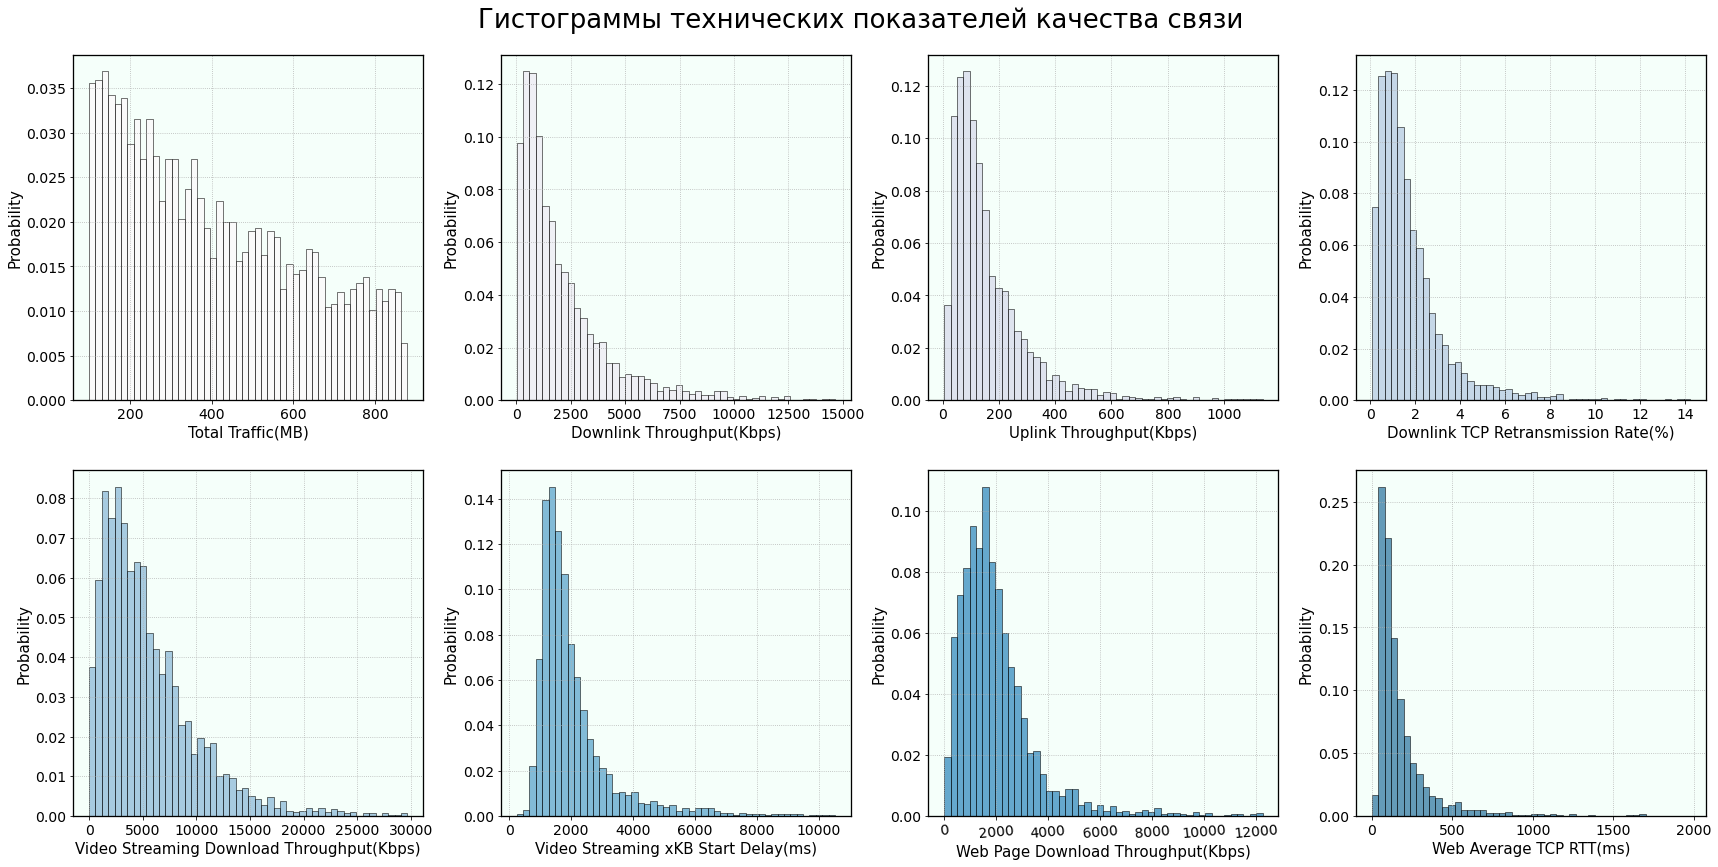

In [14]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
for i, axc in enumerate(ax.ravel()):
    sns.histplot(data = df3, x = df3.iloc[:, i+3], color = colors[i], bins = 50, stat = "probability", common_norm = False, alpha = 0.6, ax = axc)
ax[1, 2].tick_params(axis='x', labelrotation=5)
plt.suptitle("Гистограммы технических показателей качества связи", y = 1, fontsize = 26)
plt.tight_layout(h_pad = 3, w_pad = 0.5)
plt.show()

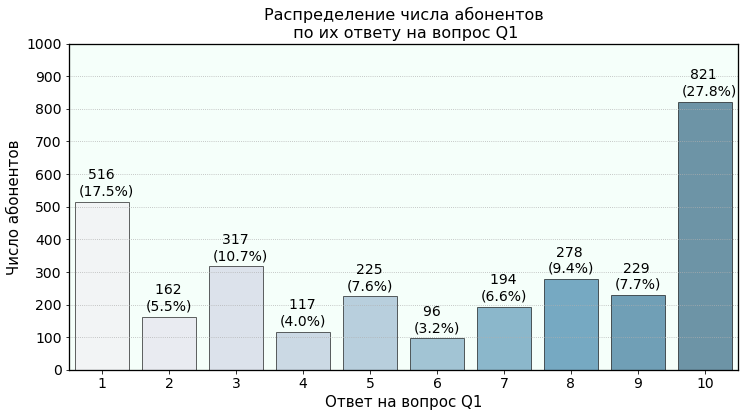

In [15]:
fig, ax = plt.subplots(figsize = (12, 6))
q_count = df3.groupby("Q1")["Q1"].count()
sns.barplot(x = q_count.index, y = q_count, ax = ax, alpha = 0.6, palette = "PuBu", edgecolor = "black")
off_x = -0.35
off_y = 20
for i, val in enumerate(q_count.values):
    ax.text(i + off_x, val + off_y, f"  {val}\n({np.round(100*val/q_count.sum(), 1)}%)", fontsize = 14)
ax.set_xlabel("Ответ на вопрос Q1")
ax.set_ylabel("Число абонентов")
ax.set_yticks(np.arange(0, 1050, 100))
ax.set_title("Распределение числа абонентов\n по их ответу на вопрос Q1")
plt.show()

# 3. Статистический анализ по ответам на вопрос Q1

## 3.1 Общие соображение о разделении абонентов на страты

Для статистического анализа и сравнения мы должны раcпределить абонентов на страты по их ответам на вопрос Q1. *Почему не подходит первоначальное разделение на 10 страт (каждая страта соответствует ответу на вопрос Q1)?*
1) Как видно из диаграммы распределения числа абонентов по их ответу на вопрос Q1, страты в этом случае будут крайне неоднородны по размеру (наибольшая - 821 пользовтель, наименьшая - 96 пользователей), что затрудняет статистическое исследование.
2) По диаграммам "ящик с усами", построенным ниже, видно, что нет четкой монотонной зависимости ни по одному из показателей от ответа на Q1. Это связано в том числе и с человеческим фактором: для каждого пользователя критеррии оценки разные и, если мы можем предполагать, что пользователь, поставивший оценку 1, скорее всего, действительно имеет менее качественный сервис, чем тот, кто поставил 10, то между ответами 5 и 6 граница будет куда более размытой.

Соображения, изложенные выше, наводят на мысль, что целесообразно использовать укрупненные страты (в каждой страте - несколько различных ответов на Q1). Сначала была предпринята попытка поделить на "объективное" число страт с использованием алгоритмов кластеризации и понижения размерности, однако не удалось достичь устойчивого результата (данные оказались слишком "запутанными" для этих алгоритмов). Тогда было принято решение разделить абонентов на страты следующим образом: ***страта 1 - плохие оценки (1-3), страта 2 - нейтральные оценки (4 - 8), страта 3 - хорошие оценки (9, 10).***

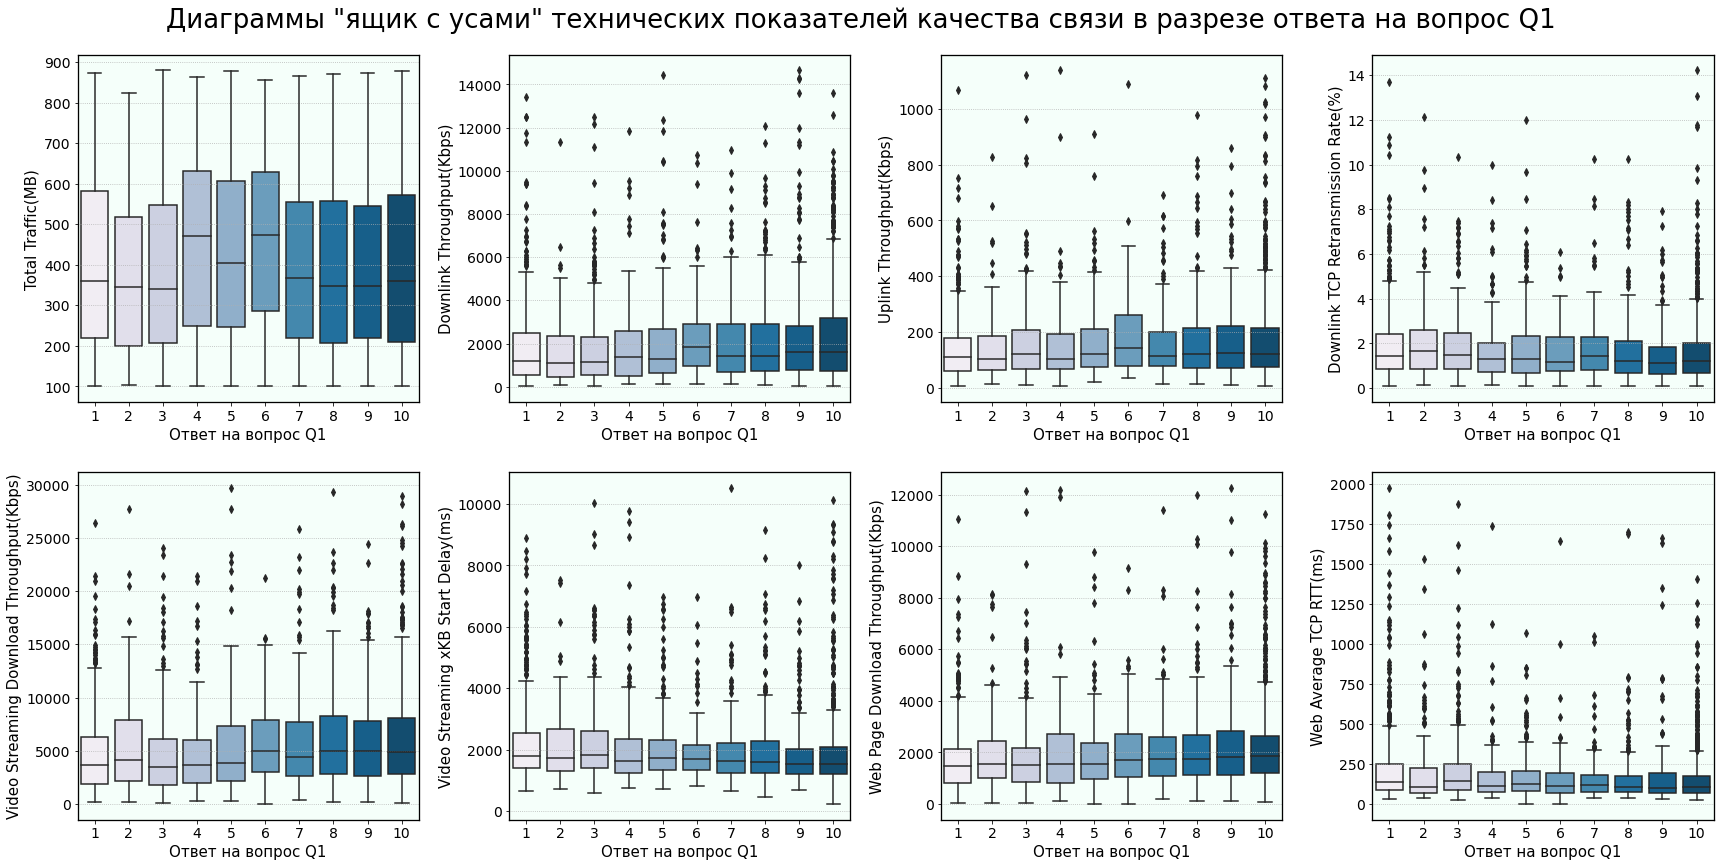

In [16]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
for i, axc in enumerate(ax.ravel()):
    sns.boxplot(data = df3, y = df3.columns[i+3], x = "Q1", ax = axc, palette = "PuBu")
    axc.set_xlabel("Ответ на вопрос Q1")
plt.suptitle('Диаграммы "ящик с усами" технических показателей качества связи в разрезе ответа на вопрос Q1', y = 1, fontsize = 26)
plt.tight_layout(h_pad = 3, w_pad = 2)
plt.show()

Разделение на страты в соответствии с описанным выше:

In [17]:
df3["stratum"] = np.digitize(df3.Q1, bins = [4, 9])+1
df3.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),stratum
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83,2
1,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,2
2,3,1,[4],261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485,1
3,4,8,[3],179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51,2
4,5,2,"[2, 3, 4]",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68,1


Численность страт:

In [18]:
df3.stratum.value_counts()

3    1050
1     995
2     910
Name: stratum, dtype: int64

Видим, что теперь страты достаточно однородны по числу абонентов. Визуализируем распределения технических показателей качества связи в разрезе страт с помощью диаграмм "ящик с усами":

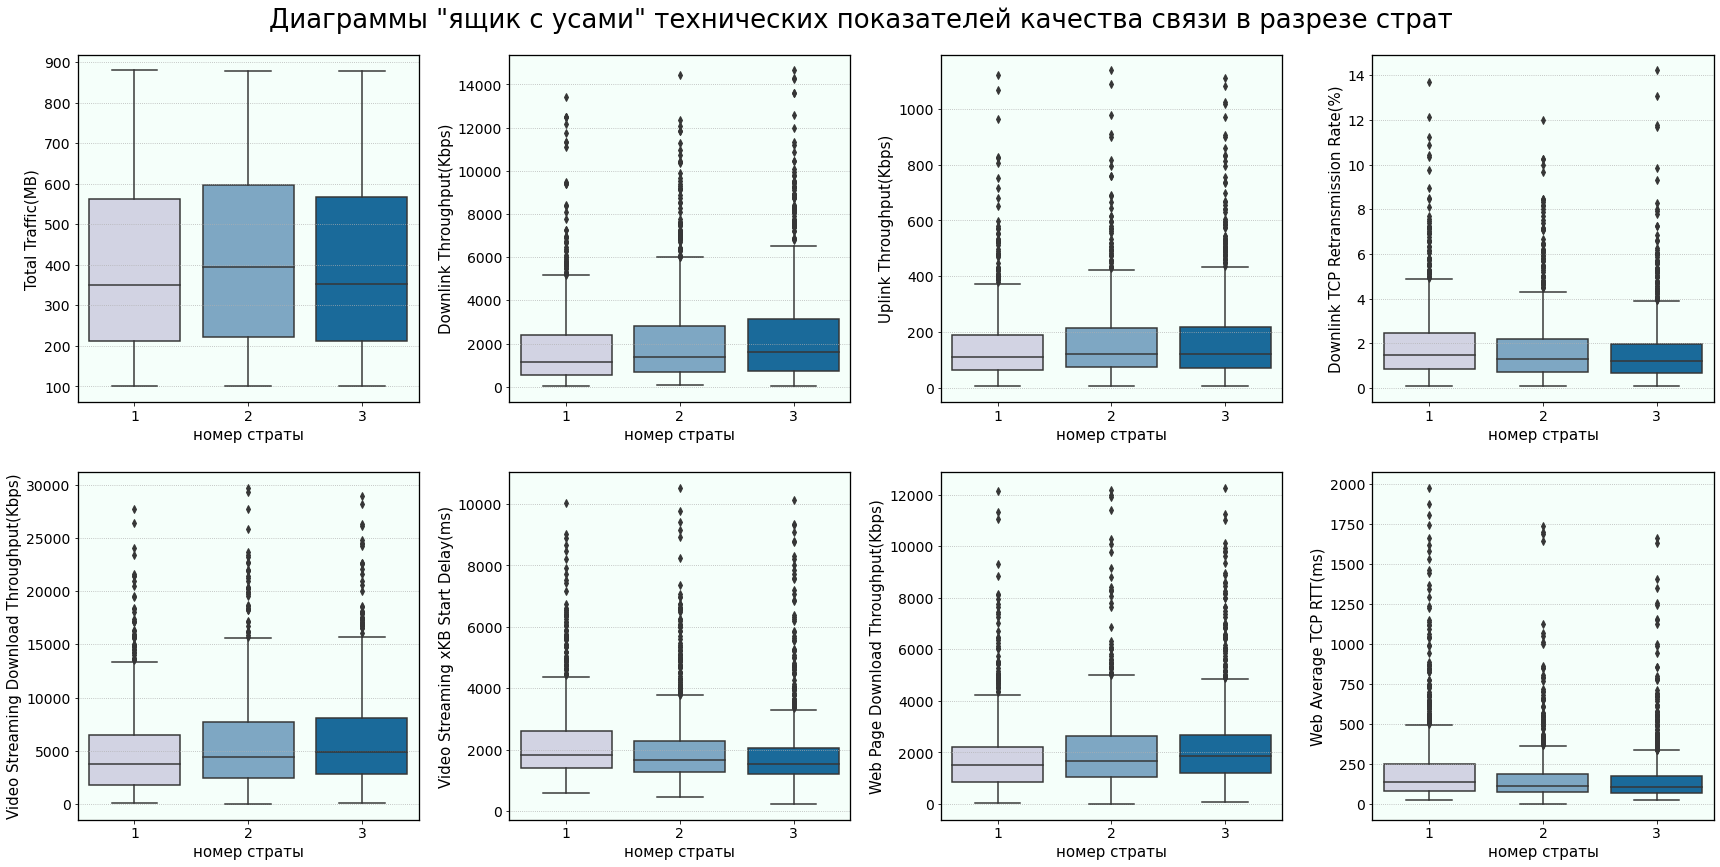

In [19]:
fig, ax = plt.subplots(2, 4, figsize = (24, 12))
for i, axc in enumerate(ax.ravel()):
    sns.boxplot(data = df3, y = df3.columns[i+3], x = "stratum", ax = axc, palette = "PuBu")
    axc.set_xlabel("номер страты")
plt.suptitle('Диаграммы "ящик с усами" технических показателей качества связи в разрезе страт', y = 1, fontsize = 26)
plt.tight_layout(h_pad = 3, w_pad = 2)
plt.show()

## 3.2 Статистические тесты

Из гистограмм и диаграмм предыдущих пунктов наглядно видно, что распределение ни одного из показателей не является нормальным. Однако, проверим это формально с помощью теста Шапиро-Уилка:

In [20]:
print(f"{CBOLD}Тесты Шапиро-Уилка (если p_value < 0.05 - распределение не нормальное c доверительной вероятностью 95%):")
print(114*"-")
for col in df3.columns[3:-1]:
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    p_value = [st.shapiro(s[i]).pvalue for i in range(3)] # Тесты Колмогорова-Смирнова
    print(f"{CBOLD}{col}{CEND}:")
    print(f"страта 1: p_value = {CGREEN}{p_value[0]:.4f}{CEND}    страта 2: p_value = {CGREEN}{p_value[1]:.4f}{CEND}    страта 3: p_value = {CGREEN}{p_value[2]:.4f}{CEND}")
    print(86*"-")

Тесты Шапиро-Уилка (если p_value < 0.05 - распределение не нормальное c доверительной вероятностью 95%):
------------------------------------------------------------------------------------------------------------------
Total Traffic(MB):
страта 1: p_value = 0.0000    страта 2: p_value = 0.0000    страта 3: p_value = 0.0000
--------------------------------------------------------------------------------------
Downlink Throughput(Kbps):
страта 1: p_value = 0.0000    страта 2: p_value = 0.0000    страта 3: p_value = 0.0000
--------------------------------------------------------------------------------------
Uplink Throughput(Kbps):
страта 1: p_value = 0.0000    страта 2: p_value = 0.0000    страта 3: p_value = 0.0000
--------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%):
страта 1: p_value = 0.0000    страта 2: p_value = 0.0000    страта 3: p_value = 0.0000
---------------------------------------------------------------

Наши предположения подтвердились, распределения не являются нормальными. Поэтому для проверки того, ***есть ли статистически значимые различия по каждому из показателей между стратами (нулевые гипотезы - это то, что их нету)***, нужно использовать непараметрические критерии. Начнем с критерия Краскела - Уоллиса: он покажет, есть ли статистически значимая разница между медианами в стратах, или же все страты сэмплированы из одного распределения. Заметим, что критерий показывает только то, взяты ли все три страты из одного распределения, или же нет, не говоря о том, как различаются между собой страты. Например, если две страты взяты из одного распределения, а третья - из другого, то критерий покажет p_value ниже заданного уровня значимости. Поэтому после необходимо провести дополнительные попарные тесты между стратами. Критерий Краскелла - Уоллиса же позволит избавиться от проверок для тех показателей, у которых нет статистически значимой разницы медиан между всеми тремя стратами (если такие показатели имеются).

In [21]:
print(f"{CBOLD}Тесты  Краскела - Уолиса (если p_value < 0.05 - не все страты взяты из одного распределения с доверительной вероятностью 95%)")
print(125*"-")
for col in df3.columns[3:-1]:
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    p_value = st.kruskal(*s).pvalue
    print(f"{CBOLD}{col}:{CEND} p_value = {CGREEN}{p_value:.4f}{CEND}")
    print(60*"-")

Тесты  Краскела - Уолиса (если p_value < 0.05 - не все страты взяты из одного распределения с доверительной вероятностью 95%)
-----------------------------------------------------------------------------------------------------------------------------
Total Traffic(MB): p_value = 0.0444
------------------------------------------------------------
Downlink Throughput(Kbps): p_value = 0.0000
------------------------------------------------------------
Uplink Throughput(Kbps): p_value = 0.0016
------------------------------------------------------------
Downlink TCP Retransmission Rate(%): p_value = 0.0000
------------------------------------------------------------
Video Streaming Download Throughput(Kbps): p_value = 0.0000
------------------------------------------------------------
Video Streaming xKB Start Delay(ms): p_value = 0.0000
------------------------------------------------------------
Web Page Download Throughput(Kbps): p_value = 0.0000
---------------------------------------

По результатам тестов Краскела - Уоллиса мы видим, что для каждого показателя хотя бы у одной пары страт есть статистически значимая разница медиан. Чтобы выяснить, между какими именно стратами, проведем дополнительные тесты. Будем использовать тест Манна - Уитни, бутстрэп и перестановочный тест.

Сначала проведем тест Манна-Уитни. Условием корректного применения критерия  Манна-Уитни является то, что в выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10). Проверим, так ли это:

In [22]:
for col in df3.columns[3:-1]:
    print(f"{CBOLD}{col}{CEND}:")
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    for i in range(3):
        print(f"{CBLUE}Страта {i+1}{CEND}:\tчисло наблюдений: {len(s[i])}\tчисло уникальных наблюдений: {s[i].nunique()}")
    print(74*"-")

Total Traffic(MB):
Страта 1:	число наблюдений: 995	число уникальных наблюдений: 995
Страта 2:	число наблюдений: 910	число уникальных наблюдений: 910
Страта 3:	число наблюдений: 1050	число уникальных наблюдений: 1050
--------------------------------------------------------------------------
Downlink Throughput(Kbps):
Страта 1:	число наблюдений: 995	число уникальных наблюдений: 995
Страта 2:	число наблюдений: 910	число уникальных наблюдений: 908
Страта 3:	число наблюдений: 1050	число уникальных наблюдений: 1046
--------------------------------------------------------------------------
Uplink Throughput(Kbps):
Страта 1:	число наблюдений: 995	число уникальных наблюдений: 980
Страта 2:	число наблюдений: 910	число уникальных наблюдений: 900
Страта 3:	число наблюдений: 1050	число уникальных наблюдений: 1028
--------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%):
Страта 1:	число наблюдений: 995	число уникальных наблюдений: 404
Страта 2:	ч

Видно, что для **Downlink TCP Retransmission Rate(%)**, **Video Streaming xKB Start Delay(ms)**, **Web Average TCP RTT(ms)** это условие грубо нарушается. Поэтому проведем тест Манна-Уитни для оставшихся метрик. 

In [23]:
print(f"{CBOLD}Тесты Манна - Уитни:")
print(20*"-")
def color(p_value):
    return CRED if p_value >= 0.05 else CGREEN
for col in df3.columns[[3, 4, 5, 7, 9]]:
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    p_value = [st.mannwhitneyu(s[0], s[1]).pvalue, st.mannwhitneyu(s[1], s[2]).pvalue, st.mannwhitneyu(s[0], s[2]).pvalue] # Тесты Манна - Уитни
    print(f"{CBOLD}{col}{CEND}:")
    print(f"страта 1 и страта 2: p_value = {color(p_value[0])}{p_value[0]:.4f}{CEND}    страта 2 и страта 3: p_value = {color(p_value[1])}{p_value[1]:.4f}{CEND}   страта 1 и страта 3: p_value = {color(p_value[2])}{p_value[2]:.4f}{CEND}")
    print(118*"-")

Тесты Манна - Уитни:
--------------------
Total Traffic(MB):
страта 1 и страта 2: p_value = 0.0234    страта 2 и страта 3: p_value = 0.0368   страта 1 и страта 3: p_value = 0.8599
----------------------------------------------------------------------------------------------------------------------
Downlink Throughput(Kbps):
страта 1 и страта 2: p_value = 0.0000    страта 2 и страта 3: p_value = 0.0273   страта 1 и страта 3: p_value = 0.0000
----------------------------------------------------------------------------------------------------------------------
Uplink Throughput(Kbps):
страта 1 и страта 2: p_value = 0.0059    страта 2 и страта 3: p_value = 0.5732   страта 1 и страта 3: p_value = 0.0008
----------------------------------------------------------------------------------------------------------------------
Video Streaming Download Throughput(Kbps):
страта 1 и страта 2: p_value = 0.0000    страта 2 и страта 3: p_value = 0.0262   страта 1 и страта 3: p_value = 0.0000
-----------

Для исследования показателей **Downlink TCP Retransmission Rate(%)**, **Video Streaming xKB Start Delay(ms)**, **Web Average TCP RTT(ms)**, а также для уточнения результатов тетса Манна-Уитни будем использовать методы с ресэмплированием (перестановочный тест и бутстрэп). Кроме того, эти методы являются более робастными в сравнении с тестами Манна-Уитни. Функциональность бутсрэпа реализована в классе bootstrap, перестановочного теста - в классе permute. Ниже приведены результаты бутстрэп-тестов и перестановочных тестов для медиан показателей (медиана выбрана, как более робастный показатель по сравнению со средним значением, особенно принимая во внимание вид наших распределений).

In [24]:
class bootstrap:
    """
        Class that implements the bootstrap method
        
        Parameters
        ----------
        n_samples: int, default: 10000
            Number of bootstrap iterations
        statistic: callable, default: np.mean
            Statistic for which the confidence interval is to be calculated.
    """
    
    def __init__(self, n_samples = 20000, statistic = np.mean):
        self.n_samples = n_samples
        self.statistic = statistic
        self.confint_blank = namedtuple("BootstrapConfints", ["lower_bound_1", "upper_bound_1", "lower_bound_2", "upper_bound_2"], defaults = [None]*4)
        self.confint = None
        self.intersect = False
                
    def run(self, seq1, seq2 = None, alpha = 0.05):
        """
            Run the bootstrap procedure.
        
            Parameters
            ----------
            seq1: array-like.
                First sequence to be bootstrapped 
            seq2: array-like, default: None
                Second sequence to be bootstrapped 
            alpha: float, default: 0.05
                Significance level
                
            Returns
            ----------
            bootstrap object.
        """
        self.samples_1 = [] # bootstrap-samples for the first sequence
        self.samples_2 = [] # bootstrap-samples for the second sequence
        rng = np.random.RandomState(0)
        for i in range(self.n_samples):
            self.samples_1.append(self.statistic(rng.choice(seq1, size = len(seq1))))
        self.confint = self.confint_blank(np.quantile(self.samples_1, alpha/2), np.quantile(self.samples_1, 1 - alpha/2))
        
        if seq2 is not None:
            for i in range(self.n_samples):
                self.samples_2.append(self.statistic(rng.choice(seq2, size = len(seq2))))
            self.confint = self.confint._replace(lower_bound_2 = np.quantile(self.samples_2, alpha/2), upper_bound_2 = np.quantile(self.samples_2, 1 - alpha/2))
       
        low_max = max(self.confint.lower_bound_1, self.confint.lower_bound_2)
        high_min = min(self.confint.upper_bound_1, self.confint.upper_bound_2)
        self.intersect = low_max < high_min # whether the confidence intervals intersect
        
        return self

In [25]:
class permute:
    """
        Class that implements permutation test
        
        Parameters
        ----------
        n_samples: int, default: 10000
            Number of iterations for the permutation test
        statistic: callable, default: np.mean
            Statistic which is obtained.
    """
    
    def __init__(self, n_samples = 20000, statistic = np.mean):
        self.n_samples = n_samples
        self.statistic = statistic
                    
    def run(self, seq1, seq2):
        
        """
            Run the permutation test.
        
            Parameters
            ----------
            seq1: array-like.
                First sequence for the test
            seq2: array-like, default: None
                Second sequence for the test
 
            Returns
            ----------
            permute object.
        """
        
        self.samples = np.array([]) # samples of the difference in the statistics
        n1 = len(seq1)
        n2 = len(seq2)
        total_samples = np.concatenate((s[0], s[1]))
        rng = np.random.RandomState(0)
        self.init_stat = np.abs(self.statistic(seq1) - self.statistic(seq2))
        for i in range(self.n_samples):
            rng.shuffle(total_samples)
            seq1 = total_samples[:n1]
            seq2 = total_samples[n1:]          
            self.samples = np.append(self.samples, np.abs(self.statistic(seq1) - self.statistic(seq2)))
        self.pvalue = (self.samples >= self.init_stat).sum()/self.n_samples # p-value
        return self

In [26]:
print(f"{CBOLD}Бутстрэп - тесты (доверительная вероятность для доверительных интервалов 95%):")
print(78*"-")

def color_intersect(intersect):
    if intersect:
        return CRED + "пересекаются" + CEND
    else:
        return CGREEN + "не пересекаются" + CEND
    
for col in df3.columns[3:-1]:
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    boot_median_1 = bootstrap(statistic = np.median).run(s[0], s[1])
    boot_median_2 = bootstrap(statistic = np.median).run(s[1], s[2])
    boot_median_3 = bootstrap(statistic = np.median).run(s[0], s[2])
    print(f"{CBOLD}{col}{CEND}:")
    print(f"\n{CBLUE}Тест для медиан{CEND}\n\
95% д.и: страта 1: [{boot_median_1.confint.lower_bound_1:.4f}, {boot_median_1.confint.upper_bound_1:.4f}]\
    страта 2: [{boot_median_1.confint.lower_bound_2:.4f}, {boot_median_1.confint.upper_bound_2:.4f}]\
    страта 3: [{boot_median_2.confint.lower_bound_2:.4f}, {boot_median_2.confint.upper_bound_2:.4f}]")
    print(f"д.и. между стратами 1 и 2 {color_intersect(boot_median_1.intersect)}, между стратами 2 и 3 {color_intersect(boot_median_2.intersect)}, между стратами 1 и 3 {color_intersect(boot_median_3.intersect)}")
    print(118*"-")

Бутстрэп - тесты (доверительная вероятность для доверительных интервалов 95%):
------------------------------------------------------------------------------
Total Traffic(MB):

Тест для медиан
95% д.и: страта 1: [333.8184, 369.0178]    страта 2: [367.4565, 416.3124]    страта 3: [334.9277, 372.4092]
д.и. между стратами 1 и 2 пересекаются, между стратами 2 и 3 пересекаются, между стратами 1 и 3 пересекаются
----------------------------------------------------------------------------------------------------------------------
Downlink Throughput(Kbps):

Тест для медиан
95% д.и: страта 1: [1093.9600, 1296.5900]    страта 2: [1279.3800, 1507.7400]    страта 3: [1510.6000, 1761.9550]
д.и. между стратами 1 и 2 пересекаются, между стратами 2 и 3 не пересекаются, между стратами 1 и 3 не пересекаются
----------------------------------------------------------------------------------------------------------------------
Uplink Throughput(Kbps):

Тест для медиан
95% д.и: страта 1: [104.4700, 119.24

In [27]:
print(f"{CBOLD}Перестановочные тесты:{CEND}")
print(22*"-")
for col in df3.columns[3:-1]:
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    p_value_1 = permute(statistic = np.median).run(s[0], s[1]).pvalue
    p_value_2 = permute(statistic = np.median).run(s[1], s[2]).pvalue
    p_value_3 = permute(statistic = np.median).run(s[0], s[2]).pvalue
    print(f"{CBOLD}{col}{CEND}:")
    print(f"страта 1 и страта 2: p_value = {color(p_value_1)}{p_value_1:.4f}{CEND}    страта 2 и страта 3: p_value = {color(p_value_2)}{p_value_2:.4f}{CEND}   страта 1 и страта 3: p_value = {color(p_value_3)}{p_value_3:.4f}{CEND}")
    print(118*"-")

Перестановочные тесты:
----------------------
Total Traffic(MB):
страта 1 и страта 2: p_value = 0.0054    страта 2 и страта 3: p_value = 0.0066   страта 1 и страта 3: p_value = 0.9606
----------------------------------------------------------------------------------------------------------------------
Downlink Throughput(Kbps):
страта 1 и страта 2: p_value = 0.0047    страта 2 и страта 3: p_value = 0.0083   страта 1 и страта 3: p_value = 0.0000
----------------------------------------------------------------------------------------------------------------------
Uplink Throughput(Kbps):
страта 1 и страта 2: p_value = 0.1318    страта 2 и страта 3: p_value = 0.6197   страта 1 и страта 3: p_value = 0.0597
----------------------------------------------------------------------------------------------------------------------
Downlink TCP Retransmission Rate(%):
страта 1 и страта 2: p_value = 0.0152    страта 2 и страта 3: p_value = 0.1700   страта 1 и страта 3: p_value = 0.0000
-------------

Видим, что в большинстве случаев бутстрэп и перестановочные тесты дали одинаковые результаты, однако есть и отличия:
- **Total Traffic(MB)**: перестановочный тест показывает статистически значимую разницу между стратами 1 и 2, 2 и 3; доверительные же интервалы, полученные бутстрэпом, пересекаются (1 с 2 и 2 с 3), однако области пересечения малы (по сравнению с ширинами доверительных интервалов);
- **Downlink Throughput(Kbps)**: перестановочный тест всюду показывает статистически значимую разницу; доверительные же интервалы, полученные бутстрэпом, пересекаются (1 c 2), однако область пересечения мала (по сравнению с ширинами доверительных интервалов);
- **Downlink TCP Retransmission Rate(%)**: перестановочный тест показывает статистически значимую разницу между стратами 1 и 2;  доверительные же интервалы, полученные бутстрэпом для страт 1 и 2, пересекаются, однако область пересечения мала по сравнению с ширинами доверительных интервалов);
- **Video Streaming Download Throughput(Kbps)**: перестановочный тест всюду показывает статистически значимую разницу; доверительные же интервалы, полученные бутстрэпом для страт 2 и 3, пересекаются, однако область пересечения мала по сравнению с ширинами доверительных интервалов);



Видим, что между стратами 1 и 3 и бутсрэп, и перестановочные тесты показывают статистическую значимость всюду, кроме **Uplink Throughput(Kbps)** и **Total Traffic(MB)**. Для страт 1 и 2, 2 и 3 разница уже не так ярко выражена, и в некоторых случаях результаты бутстрэпа и перестановочного теста разные (хотя и на границах уровней значимости и пересечения доверительных интервалов). Именно для оценки статистической значимости в разнице какого-либо показателя между выборками перестановочный тест считается более точным (бутстрэп же предпочтителен для оценки доверительных интервалов), поэтому будем ориентироваться на результаты, полученные с помощью него. Ниже для наглядности проиллюстрированы результаты бутсрэпа и перестановочного теста для показателей **Video Streaming xKB Start Delay(ms)** и **Uplink Throughput(Kbps)** (для остальных показателей картинки аналогичны). Для бутстрэпа также приведены тесты для средних, хотя мы их и не используем в исследовании, просто для иллюстрации того, что методы ресэмплирования применимы для оценки любых статистик.

In [28]:
def bootstrap_plot(col, axs):
    """
        Auxiliary function to plot bootstrap diagrams
    """
    local_colors = cm.get_cmap("Set1").colors
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    b1 = bootstrap(statistic = np.median).run(s[0], s[1])
    b2 = bootstrap(statistic = np.median).run(s[1], s[2])
    b3 = bootstrap().run(s[0], s[1])
    b4 = bootstrap().run(s[1], s[2])
    stratums1 = [b1.samples_1, b1.samples_2, b2.samples_2]
    intervals1 = [(b1.confint.lower_bound_1, b1.confint.upper_bound_1), (b1.confint.lower_bound_2, b1.confint.upper_bound_2), (b2.confint.lower_bound_2, b2.confint.upper_bound_2)]
    stratums2 = [b3.samples_1, b3.samples_2, b4.samples_2]
    intervals2 = [(b3.confint.lower_bound_1, b3.confint.upper_bound_1), (b3.confint.lower_bound_2, b3.confint.upper_bound_2), (b4.confint.lower_bound_2, b4.confint.upper_bound_2)]
    for i in range(3):        
        axs[0].hist(stratums1[i], color = local_colors[i], alpha = 0.4, bins = 30, edgecolor = "black", label = f"страта {i+1}", density = True)
        axs[0].axvline(intervals1[i][0], color = local_colors[i], linewidth = 3, linestyle = "--")
        axs[0].axvline(intervals1[i][1], color = local_colors[i], linewidth = 3, linestyle = "--")
        axs[0].set_title("Бутстрэп-тест для медиан", fontsize = 18)
        axs[1].hist(stratums2[i], color = local_colors[i], alpha = 0.4, bins = 30, edgecolor = "black", label = f"страта {i+1}", density = True)
        axs[1].axvline(intervals2[i][0], color = local_colors[i], linewidth = 3, linestyle = "--")
        axs[1].axvline(intervals2[i][1], color = local_colors[i], linewidth = 3, linestyle = "--")
        axs[1].set_title("Бутстрэп-тест для средних", fontsize = 18)
    for i in (0, 1):
        axs[i].set_ylabel("Probability density")
        axs[i].set_xlabel(col)
        axs[i].legend(edgecolor = "black", facecolor = "white", loc = "upper right")

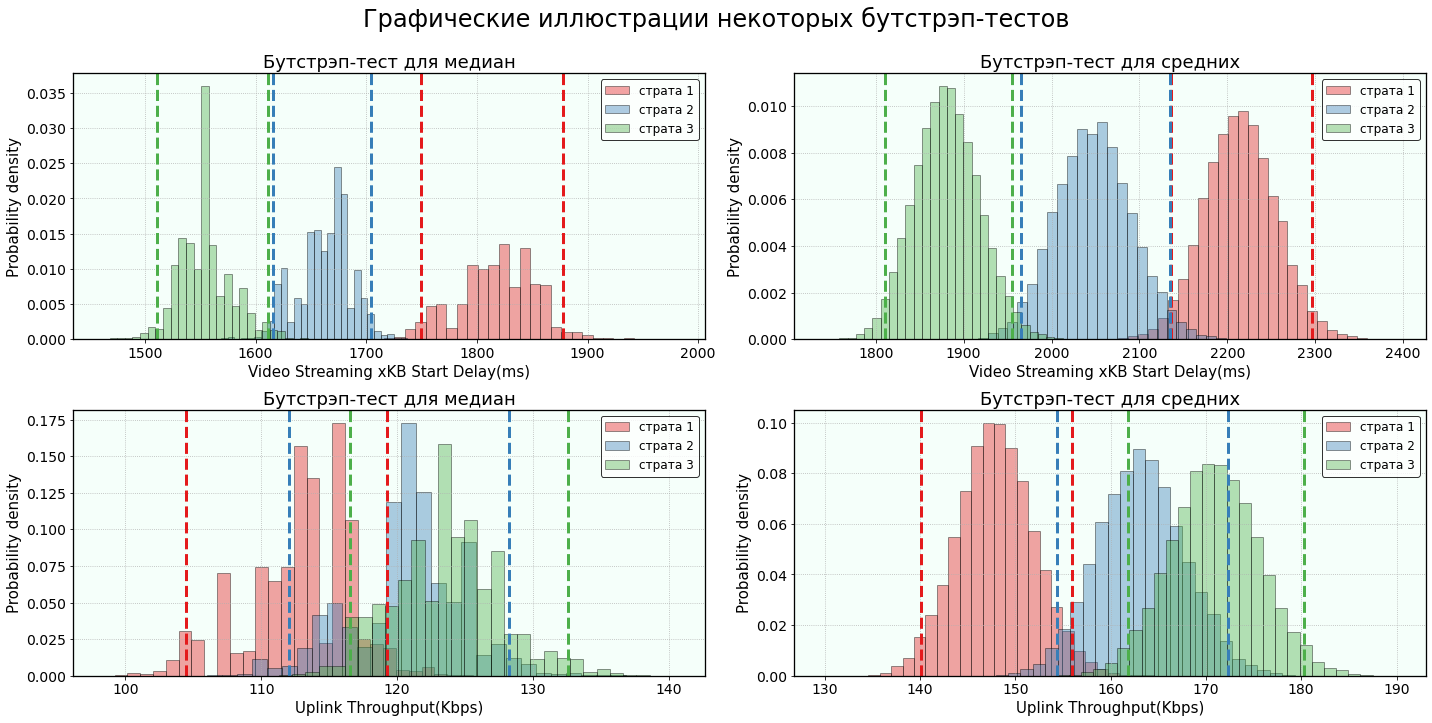

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))
axc = ax.ravel()
col = "Video Streaming xKB Start Delay(ms)"
bootstrap_plot(col, axc[:2])
col = "Uplink Throughput(Kbps)"
bootstrap_plot(col, axc[2:])
plt.suptitle('Графические иллюстрации некоторых бутстрэп-тестов', y = 1, fontsize = 24)
plt.tight_layout()

In [30]:
def permute_plot(col, axs):
    """
        Auxiliary function to plot diagrams for permutation tests
    """
    local_colors = cm.get_cmap("Set1").colors
    s = [df3.loc[df3.stratum == i, col] for i in range(1, 4)]
    p1 = permute(statistic = np.median).run(s[0], s[1])
    p2 = permute(statistic = np.median).run(s[1], s[2])
    p3 =  permute(statistic = np.median).run(s[0], s[2])
    stratums = [p1.samples, p2.samples, p3.samples]
    stats = [p1.init_stat, p2.init_stat, p3.init_stat]
    for i in range(3):
        end = i+2 if i!=2 else 1
        axs[i].hist(stratums[i], color = local_colors[i], alpha = 0.4, bins = 20, edgecolor = "black", label = f"cэмплы\nперестановочного\nтеста", density = True)
        axs[i].axvline(stats[i], color = local_colors[i], linewidth = 3, linestyle = "--", label = "первоначальная\nразность\nмедиан")
        axs[i].set_title(f"Перестановочный тест для разности медиан\nмежду стратами {i+1} и {end}", fontsize = 18)
        axs[i].set_ylabel("Probability density")
        axs[i].set_xlabel(f"Разность медиан для показателя\n{col}")
        axs[i].legend(edgecolor = "black", facecolor = "white", loc = "best")

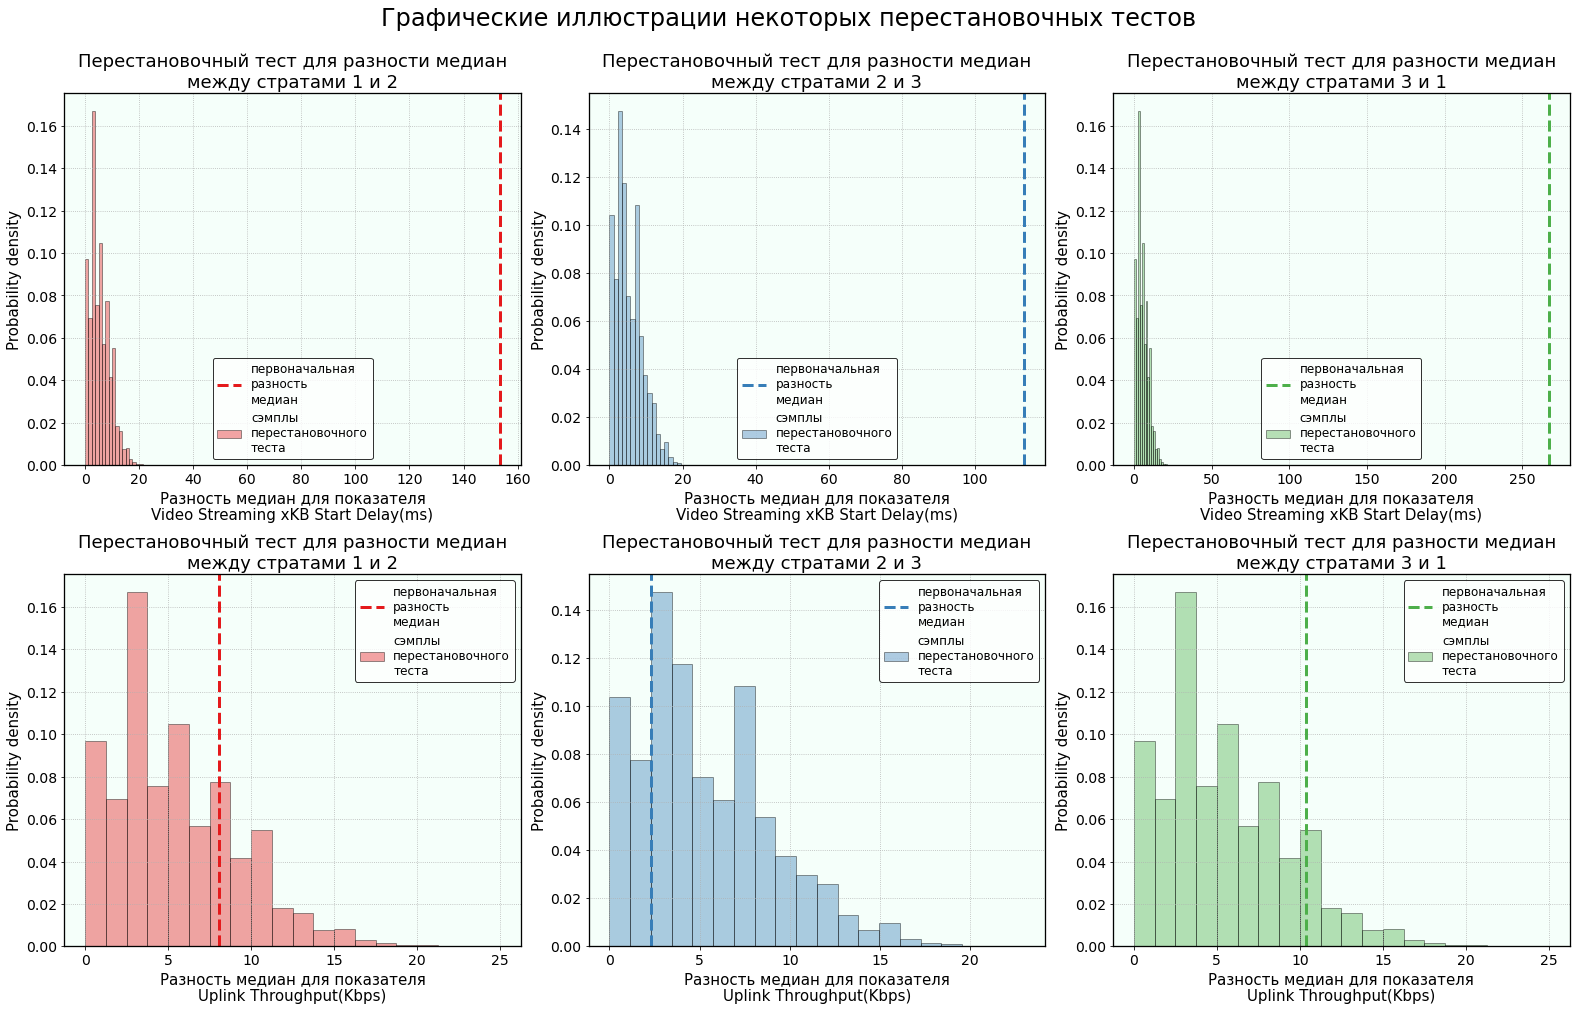

In [31]:
fig, ax = plt.subplots(2, 3, figsize = (22, 14))
axc = ax.ravel()
col = "Video Streaming xKB Start Delay(ms)"
permute_plot(col, axc[:3])
col = "Uplink Throughput(Kbps)"
permute_plot(col, axc[3:])
plt.suptitle('Графические иллюстрации некоторых перестановочных тестов', y = 1, fontsize = 24)
plt.tight_layout()

## 3.3 Корреляционный анализ

По какому показателю сильнее различия между стратами можно понять, анализируя p-value в перестановочных тестах из предыдущего пункта (чем меньше p-value, тем сильнее различия). Подтвердим эти выводы также корреляционным анализом. Поскольку stratum (страта) - порядковая категориальная пременная, корреляция Пирсона не подходит. Ищем коэффициенты корреляции Спирмена:

In [32]:
stratum_corr = df3.iloc[:, 3:-1].apply(lambda x: st.spearmanr(x, df3.stratum)[0]).to_frame()
stratum_corr.columns = ["Spearman's correlation coefficient"]
stratum_corr_s = stratum_corr.style
stratum_corr_s.format(formatter = "{:.4f}")
stratum_corr_s.background_gradient(cmap = "Blues")
stratum_corr_s.applymap(lambda x: "text-align: center")

,Spearman's correlation coefficient
Total Traffic(MB),0.0024
Downlink Throughput(Kbps),0.1243
Uplink Throughput(Kbps),0.0617
Downlink TCP Retransmission Rate(%),-0.1100
Video Streaming Download Throughput(Kbps),0.1335
Video Streaming xKB Start Delay(ms),-0.1515
Web Page Download Throughput(Kbps),0.1409
Web Average TCP RTT(ms),-0.1325


Наибольшая положительная корреляция наблюдается между стратами и **Web Page Download Throughput(Kbps)**, наибольшая (по модулю) отрицательная корреляция - между стратами и **Video Streaming xKB Start Delay(ms)**. Из предыдущего пункта видно, что для обоих этих показателей и бутстрэп, и перестановочные тесты показывают статистическую значимую разницу между всеми стратами, а перестановочные тесты дают хорошие запасы по p-value. Для **Total Traffic(MB)** и **Uplink Throughput(Kbps)** корреляция со стратами весьма слабая, это же наблюдаем и в результатах бутстрэп- и перестановочных тестов: доверительные интервалы пересекаются, статистически значимых различий между стратами нет. Т.е. корреляционный анализ подтверждает наши статистические тесты. Конечные результаты можно интерпретировать так: в первую очередь пользователь "ощущает" скорость "к абоненту", поэтому связь параметров, связанных с downlink-скоростями, со стратами намного сильнее, чем связь с uplink - скоростями (при самых распространенных использованиях интернета трафика к абоненту передается гораздо больше, чем от него). Что касается **Total Traffic(MB)**, то, как видим, он зависит больше от предпочтений конкретных абонентов и того, насколько активно они используют интернет, чем от технических показателей их соединения.

Все рассматриваемые показатели - обычные числовые переменные, поэтому для исследования их связи между собой можно использовать коэффициенты корреляции Пирсона:

In [33]:
corr_mtx = df3.iloc[:, 3:-1].corr()
corr_mtx

,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
Total Traffic(MB),1.000000,0.174200,0.041236,-0.122130,0.049870,-0.031488,0.046861,-0.071360
Downlink Throughput(Kbps),0.174200,1.000000,0.196524,-0.243038,0.553273,-0.261056,0.341107,-0.243089
Uplink Throughput(Kbps),0.041236,0.196524,1.000000,-0.147033,0.233314,-0.102271,0.210042,-0.194512
Downlink TCP Retransmission Rate(%),-0.122130,-0.243038,-0.147033,1.000000,-0.280997,0.189039,-0.243428,0.165640
Video Streaming Download Throughput(Kbps),0.049870,0.553273,0.233314,-0.280997,1.000000,-0.434896,0.481742,-0.305901
Video Streaming xKB Start Delay(ms),-0.031488,-0.261056,-0.102271,0.189039,-0.434896,1.000000,-0.241289,0.244104
Web Page Download Throughput(Kbps),0.046861,0.341107,0.210042,-0.243428,0.481742,-0.241289,1.000000,-0.300906
Web Average TCP RTT(ms),-0.071360,-0.243089,-0.194512,0.165640,-0.305901,0.244104,-0.300906,1.000000


Визуализируем результаты на тепловой карте. По шкале Чеддока показатели **Video Streaming Download Throughput(Kbps)** и **Downlink Throughput(Kbps)** имеют между собой заметную корреляцию, многие показатели имеют между собой умеренную корреляцию (от 0,3 до 0,5 по модулю).

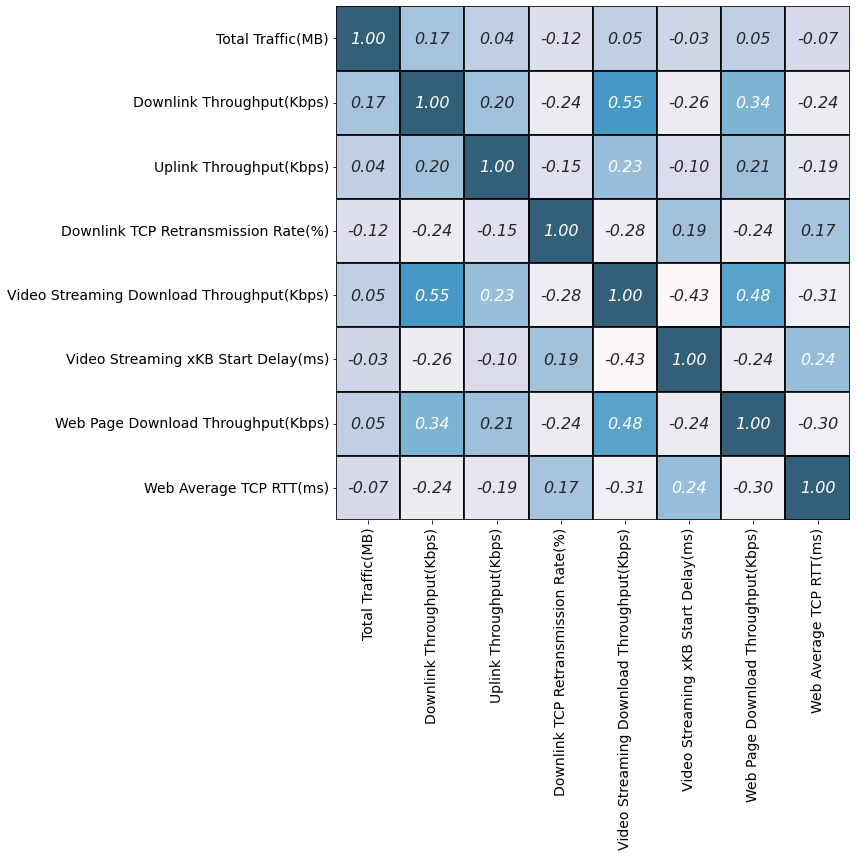

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mtx, ax = ax, alpha = 0.8, linewidths = 0.1,
            square=True, cmap= 'PuBu', linecolor='black',  annot=True, annot_kws = {'fontsize':16, 'fontstyle' : "italic"}, fmt = '.2f', cbar = False)
plt.tight_layout()
plt.show()

Наконец, продемонстрируем наглядно на гистограммах, как видно разделение пользователей на страты для наиболее сильно коррелирующего со стратами показателя **Video Streaming xKB Start Delay(ms)** и для слабо коррелирующего показателя **Uplink Throughput(Kbps)**:

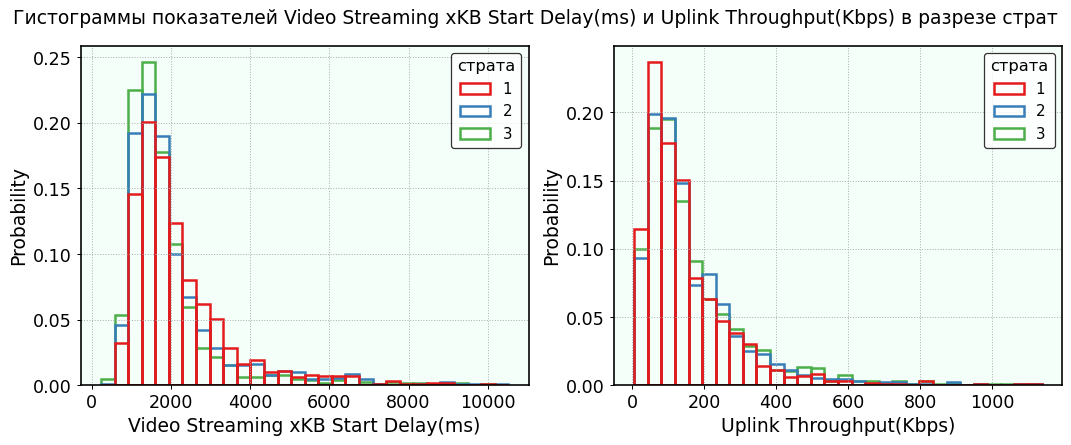

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 90)
sns.histplot(data = df3, x = "Video Streaming xKB Start Delay(ms)", hue = "stratum", bins = 30, stat = "probability", common_norm = False, palette = "Set1", fill = False, ax = ax[0], linewidth = 2)
sns.histplot(data = df3, x = "Uplink Throughput(Kbps)", hue = "stratum", bins = 30, stat = "probability", common_norm = False, palette = "Set1", fill = False, ax = ax[1], linewidth = 2)
ax[0].get_legend().set_title("страта")
ax[1].get_legend().set_title("страта")
plt.suptitle("Гистограммы показателей Video Streaming xKB Start Delay(ms) и Uplink Throughput(Kbps) в разрезе страт", fontsize = 15)
plt.tight_layout()

По гистограм видно, что в случае **"Video Streaming xKB Start Delay(ms)** разделение на страты выражено четче.

# 4. Статистический анализ по ответам на вопрос Q2

Выполним предобработку датафрейма: удалим пропущенные значения в столбце Q2, введем столбцы Q2_1, Q2_3, Q2_4, которые показывают, был ли среди ответов на вопрос Q2 ответ 1, 3 и 4, соответственно (это наиболее распространенные ответы (см. п.2.2 настоящей работы, доля остальных ответов очень мала)). Также введем столбцы phone (в нем показываются, были ли проблемы у пользователя с голосовой связью, т.е. присутствовали ли ответы 1,2,3) и internet (в нем показываются, были ли проблемы у пользователя с мобильным интернетом, т.е. присутствовали ли ответы 4,5)

In [36]:
df4 = df3.dropna(subset = ["Q2"])
df4["Q2_1"] = df4.Q2.apply(lambda x: 1 in x)
df4["Q2_3"] = df4.Q2.apply(lambda x: 3 in x)
df4["Q2_4"] = df4.Q2.apply(lambda x: 4 in x)
df4["phone"] = df4.Q2.apply(lambda x: (1 in x) or (2 in x) or (3 in x))
df4["internet"] = df4.Q2.apply(lambda x: (4 in x) or (5 in x))
df4

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms),stratum,Q2_1,Q2_3,Q2_4,phone,internet
1,2,5,[4],861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425,2,False,False,True,False,True
2,3,1,[4],261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485,1,False,False,True,False,True
3,4,8,[3],179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51,2,False,True,False,True,False
4,5,2,"[2, 3, 4]",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68,1,False,True,True,True,True
6,7,2,"[4, 5]",448.88413,438.27,81.32,1.98,1699.64,4223,856.05,220,1,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,3103,8,[1],413.99008,908.59,215.83,1.62,9449.73,1467,2212.11,51,2,True,False,False,True,False
3104,3105,1,"[1, 3, 4]",206.28181,105.24,65.84,3.86,349.04,2094,1035.69,267,1,True,True,True,True,True
3107,3108,3,"[1, 4, 5]",519.96475,1045.70,44.61,0.47,4523.66,1468,1044.66,304,1,True,False,True,True,True
3108,3109,3,"[1, 3, 4, 5]",171.52629,670.32,40.94,2.35,1711.54,2780,954.91,251,1,True,True,True,True,True


Сначала проведем статистические тесты по ответам 1, 3, 4. Нулевые гипотезы: 

- процент людей, у которых в ответе на вопрос Q2 был вариант ответа 1, одинаков в страте 1 и страте 2;
- процент людей, у которых в ответе на вопрос Q2 был вариант ответа 3, одинаков в страте 1 и страте 2;
- процент людей, у которых в ответе на вопрос Q2 был вариант ответа 4, одинаков в страте 1 и страте 2.

Для тестирования этих гипотез подходящим является критерий хи-квадрат Пирсона, его и будем использовать.

In [37]:
#Создаем вспомогательные датафреймы для статистических тестов:
for i in (1, 3, 4):
    exec(f"""df_q2{i} = df4.groupby(["stratum", "Q2_{i}"], as_index = False).agg(number_of_users = ("user_id", "count"))
df_q2{i}["total_users_in_stratum"] = df_q2{i}.groupby("stratum")["number_of_users"].transform("sum")
df_q2{i}["percent"] = df_q2{i}["number_of_users"]/df_q2{i}["total_users_in_stratum"]""")
    
#Функция стилизации датафрейма. Синим выделеляются строки, соответствующие пользователям, выбравшим рассматриваемый вариант ответа на вопрос Q2 (1, 3, 4)    
def set_prop2(x, props = ''):
    """
        This function applies styling properties to dataframe
    """
    return [props for i in x] if x[1] else [None for i in x]

In [38]:
df_q21_s = df_q21.style.format(formatter = "{:.2f}", subset = ["percent"])
df_q21_s.apply(set_prop2, props = "background-color: blue; color: white; opacity: 0.5", axis = 1)

,stratum,Q2_1,number_of_users,total_users_in_stratum,percent
0,1,False,283,633,0.45
1,1,True,350,633,0.55
2,2,False,355,623,0.57
3,2,True,268,623,0.43


In [39]:
df_q23_s = df_q23.style.format(formatter = "{:.2f}", subset = ["percent"])
df_q23_s.apply(set_prop2, props = "background-color: blue; color: white; opacity: 0.5", axis = 1)

,stratum,Q2_3,number_of_users,total_users_in_stratum,percent
0,1,False,274,633,0.43
1,1,True,359,633,0.57
2,2,False,305,623,0.49
3,2,True,318,623,0.51


In [40]:
df_q24_s = df_q24.style.format(formatter = "{:.2f}", subset = ["percent"])
df_q24_s.apply(set_prop2, props = "background-color: blue; color: white; opacity: 0.5", axis = 1)

,stratum,Q2_4,number_of_users,total_users_in_stratum,percent
0,1,False,307,633,0.48
1,1,True,326,633,0.52
2,2,False,350,623,0.56
3,2,True,273,623,0.44


In [41]:
print(f"{CBOLD}Тесты по критерию хи-квадрат Пирсона:{CEND}")
print(36*"-")
for i in (1, 3, 4):
    exec(f"""p_value = proportions_chisquare(df_q2{i}.iloc[[1, 3], 2], df_q2{i}.iloc[[1, 3], 3])[1]""")
    print(f"{CBOLD}Нулевая гипотеза: процент людей с ответом {i} на Q2 одинаков в страте 1 и страте 2{CEND}: p_value = {color(p_value)}{p_value:.4f}{CEND}")
    print(100*"-")

Тесты по критерию хи-квадрат Пирсона:
------------------------------------
Нулевая гипотеза: процент людей с ответом 1 на Q2 одинаков в страте 1 и страте 2: p_value = 0.0000
----------------------------------------------------------------------------------------------------
Нулевая гипотеза: процент людей с ответом 3 на Q2 одинаков в страте 1 и страте 2: p_value = 0.0438
----------------------------------------------------------------------------------------------------
Нулевая гипотеза: процент людей с ответом 4 на Q2 одинаков в страте 1 и страте 2: p_value = 0.0064
----------------------------------------------------------------------------------------------------


По результатам статистических тестов всюду отклоняем нулевую гипотезу: процент людей с каждым из ответов 1, 3, 4 выше в страте 1, нежели в страте 2 (напомним, что люди в страте 1 оценивают сервис ниже, чем в страте 2). Из этого следует, что следующие причины: "недозвоны, обрывы при звонках", "плохое качество связи в зданиях, торговых центарх и т.д.", "медный мобильный интернет" связаны с общей оценкой человеком сервиса (общая оценка - это ответ на вопрос Q1, который определеяет страту, в которую попадает пользователь).

Попробуем выяснить, что сильнее влияет на общую оценку пользователем сервиса: качество голосовой связи или мобильного интернета. Для этого разделим пользователей на две группы: первая - пользователи, у которых возникали проблемы с голосовой связью (в столбце "phone" - True), но не было проблем с интернетом (в столбце "internet" - False); вторая - пользователи, у которых возникали проблемы с интернетом (в столбце "internet" - True), но не было проблем с голосовой связью (в столбце "phone" - False):

In [42]:
df_phone = df4[(df4.phone) & ~(df4.internet)]
df_internet = df4[~(df4.phone) & (df4.internet)]

In [43]:
df_phone = df_phone.groupby("stratum").agg(number_of_users = ("user_id", "count"))
df_phone["percent"] =np.round(100*df_phone.number_of_users/df_phone.number_of_users.sum(), 2)
df_phone

,number_of_users,percent
stratum,,
1,262,47.46
2,290,52.54


In [44]:
df_internet = df_internet.groupby("stratum").agg(number_of_users = ("user_id", "count"))
df_internet["percent"] =np.round(100*df_internet.number_of_users/df_internet.number_of_users.sum(), 2)
df_internet

,number_of_users,percent
stratum,,
1,87,43.07
2,115,56.93


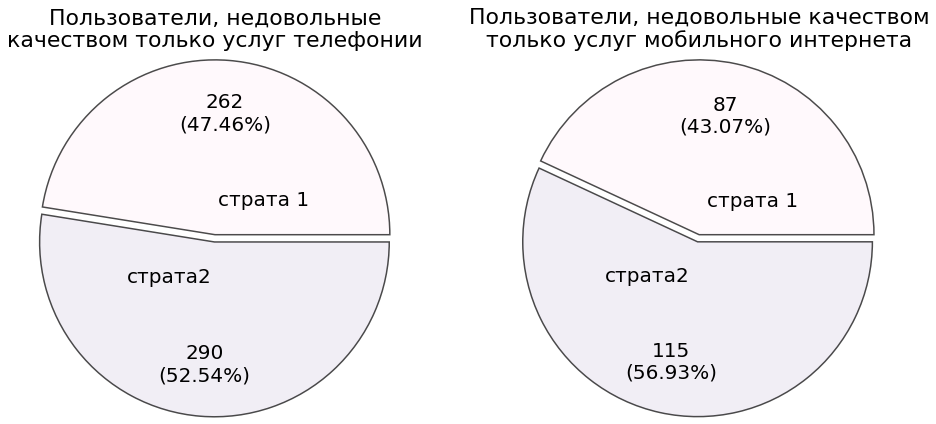

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
explode = [0 , 0.05]
labels = ["страта 1", "страта2"]
ax[0].pie(df_phone.number_of_users, colors = colors,
            radius = 1.2, labels = labels, labeldistance = 0.2, textprops = {'size':20},
            autopct = lambda x: f'{int(np.round(x*df_phone.number_of_users.sum()/100))}\n({np.round(x, 2)}%)', 
            wedgeprops = {'alpha': 0.7, "edgecolor": "black", "linewidth": 1.5}, explode = explode, pctdistance = 0.7)
ax[0].set_title("Пользователи, недовольные\nкачеством только услуг телефонии", fontsize =22)
ax[1].pie(df_internet.number_of_users, colors = colors,
            radius = 1.2, labels = labels, labeldistance = 0.2, textprops = {'size':20},
            autopct = lambda x: f'{int(np.round(x*df_internet.number_of_users.sum()/100))}\n({np.round(x, 2)}%)', 
            wedgeprops = {'alpha': 0.7, "edgecolor": "black", "linewidth": 1.5}, explode = explode, pctdistance = 0.7)
ax[1].set_title("Пользователи, недовольные качеством\nтолько услуг мобильного интернета", fontsize = 22)
plt.tight_layout()
plt.show()

In [46]:
print(f"{CBOLD}Тест по критерию хи-квадрат Пирсона:{CEND}")
print(36*"-")
p_value = proportions_chisquare([df_phone.iloc[1,0], df_internet.iloc[1,0]], [df_phone.number_of_users.sum(), df_internet.number_of_users.sum()])[1]
print(f"{CBOLD}Нулевая гипотеза: пользователи, у которых были проблемы только с голосовой связью, и пользователи, у которых\nбыли проблемы только с интернетом, распределены по стратам 1 и 2\
 в одинаковых пропорциях{CEND}: p_value = {color(p_value)}{p_value:.4f}{CEND}")
print(108*"-")

Тест по критерию хи-квадрат Пирсона:
------------------------------------
Нулевая гипотеза: пользователи, у которых были проблемы только с голосовой связью, и пользователи, у которых
были проблемы только с интернетом, распределены по стратам 1 и 2 в одинаковых пропорциях: p_value = 0.2838
------------------------------------------------------------------------------------------------------------


Видим, что оснований отвергать нулевую гипотезу нет, и в действительности нет приоритета голосовой связи над интернетом или наоборот по отношению к оценкам сервиса  пользователями.

# 5. Выводы

В ходе проведенного исcледования было выяснено следующее:
- для каждого из рассматриваемых в работе показателей, кроме **Total Traffic(MB)** и **Uplink Throughput(Kbps)**, существует статистически значимая связь с общей оценкой сервиса пользователями (с ответами на вопрос Q1);
- наиболее сильная корреляция c ответами на вопрос Q1 наблюдается для показателей **Web Page Download Throughput(Kbps)** (положительная) и **Video Streaming xKB Start Delay(ms)** (отрицательная);
- на оценку пользователей намного сильнее влияют технические показатели канала связи "к абоненту" (downlink), чем "от абонента" (uplink), поэтому компании "Мегафон" нужно в первую очередь сосредоточиться на улучшпении показателей downlink;
- многие показатели довольно сильно связаны между собой, например, **Downlink Throughput(Kbps)** c **Video Streaming Download Throughput(Kbps)** и с **Web Page Download Throughput(Kbps)**, т.е. улучшая **Downlink Throughput(Kbps)**, компания "Мегафон" будет автоматически улучшать и другие связанные с **Downlink Throughput(Kbps)**;
- наиболее частые жалобы пользователей (ответы на вопрос Q2): "недозвоны, обрывы при звонках", "плохое качество связи в зданиях, торговых центарх и т.д", "медленный мобильный интернет", для каждого из этих ответов присутствует статистически значимая связь с пропорцией пользователей по стратам (т.е. в страте 1 (с более низкими, чем в страте 2, оценками Q1) процент пользователей с каждым из рассмотренных ответов Q2 выше, чем в страте 2);
- услуги телефонии и услуги мобильного интернета эквивалентны с точки зрения влияния на общую оценку пользователями сервиса (Q1).